In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!ls "/kaggle/input/coronahack-chest-xraydataset"

Chest_xray_Corona_dataset_Summary.csv  Coronahack-Chest-XRay-Dataset
Chest_xray_Corona_Metadata.csv


In [3]:
#Importo las librerías os y pandas para leer los archivos
import os
import pandas as pd

In [12]:
folder_base="/kaggle/input/coronahack-chest-xraydataset"
test_folder=os.path.join(folder_base,"Coronahack-Chest-XRay-Dataset","Coronahack-Chest-XRay-Dataset","test")
train_folder=os.path.join(folder_base,"Coronahack-Chest-XRay-Dataset","Coronahack-Chest-XRay-Dataset","train")
metadata_path=os.path.join(folder_base,"Chest_xray_Corona_Metadata.csv")

In [13]:
metadata_df=pd.read_csv(metadata_path,index_col=0) #No columna de índices
metadata_df.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [14]:
metadata_df["Dataset_type"].unique()
#Separo los datos de train y test
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True) #Los índices se reestablecen

test_df=metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

In [15]:
#Ahora que ya cargué los dataframes, separo un poco de la data de train para validation
from sklearn.model_selection import train_test_split
x_train_df,x_val_df=train_test_split(train_df,test_size=0.2,random_state=42) #Shuffle true por defecto

In [57]:
#Veo si hay, o no, desbalanceo de clases en los dataframes
x_train_df["Label"].value_counts(),x_val_df["Label"].value_counts(),test_df["Label"].value_counts()

(Label
 Pnemonia    3169
 Normal      1059
 Name: count, dtype: int64,
 Label
 Pnemonia    775
 Normal      283
 Name: count, dtype: int64,
 Label
 Pnemonia    390
 Normal      234
 Name: count, dtype: int64)

In [100]:
#Creo los objetos generadores para procesar y cargar la data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_o_g=ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    fill_mode="nearest",
    brightness_range=[0.5,1.5]
)

val_o_g=ImageDataGenerator(
    rescale=1/255
)

test_o_g=ImageDataGenerator(
    rescale=1/255
)

In [102]:
#Cargo la data a partir de los dataframes
train_gen=train_o_g.flow_from_dataframe(
    dataframe=x_train_df,
    directory=train_folder,
    x_col="X_ray_image_name",
    y_col="Label",
    target_size=(224,224),
    class_mode="binary",
    batch_size=20,
    shuffle=False
)

val_gen=val_o_g.flow_from_dataframe(
    dataframe=x_val_df,
    directory=train_folder,
    x_col="X_ray_image_name",
    y_col="Label",
    target_size=(224,224),
    class_mode="binary",
    batch_size=20,
    shuffle=False
)

test_gen=test_o_g.flow_from_dataframe(
    dataframe=test_df,
    directory=test_folder,
    x_col="X_ray_image_name",
    y_col="Label",
    target_size=(224,224),
    class_mode="binary",
    batch_size=20,
    shuffle=False
)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [103]:
test_df.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0021-0001.jpeg,Normal,TEST,NaN,NaN
1,IM-0019-0001.jpeg,Normal,TEST,NaN,NaN
2,IM-0017-0001.jpeg,Normal,TEST,NaN,NaN
3,IM-0016-0001.jpeg,Normal,TEST,NaN,NaN
4,IM-0015-0001.jpeg,Normal,TEST,NaN,NaN


In [104]:
for batch,label_batch in train_gen:
    print(label_batch)
    break

[1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.]


In [105]:
x_train_df.head(5) #Reviso los datos --> Pnemonia=1, Normal=0

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
3881,person395_bacteria_1794.jpeg,Pnemonia,TRAIN,NaN,bacteria
318,IM-0525-0001-0001.jpeg,Normal,TRAIN,NaN,NaN
274,IM-0450-0001.jpeg,Normal,TRAIN,NaN,NaN
4559,person670_virus_1256.jpeg,Pnemonia,TRAIN,NaN,Virus
1630,person1022_bacteria_2953.jpeg,Pnemonia,TRAIN,NaN,bacteria


# 1) VGG16 - Sin fine-tuning

In [106]:
from tensorflow.keras.applications import vgg16
VGG16=vgg16.VGG16(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet"
)

In [107]:
#Fine-tunning
VGG16.trainable=False

In [108]:
VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [109]:
#Añado algunas capas
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2

x=VGG16.output
x=layers.Flatten()(x)
x=layers.Dense(1000,activation="relu",kernel_regularizer=L2(0.01))(x) #Ir probando los valores de L2
output=layers.Dense(1,activation="sigmoid")(x)
modelo=keras.Model(VGG16.input,output)

In [110]:
modelo.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1000)                │      25,089,000 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 39,804,689 (151.84 MB)

 Trainable params: 25,090,001 (95.71 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [111]:
from tensorflow.keras.optimizers import Adam
modelo.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [112]:
#Defino el callback EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
ES=EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [113]:
#Entreno la red neuronal convolucional
modelo.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[ES]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 90s 403ms/step - accuracy: 0.8404 - loss: 4.5637 - val_accuracy: 0.9565 - val_loss: 0.3425
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 392ms/step - accuracy: 0.9209 - loss: 0.4126 - val_accuracy: 0.8951 - val_loss: 0.3718
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 394ms/step - accuracy: 0.9223 - loss: 0.3238 - val_accuracy: 0.9395 - val_loss: 0.2902
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 395ms/step - accuracy: 0.9288 - loss: 0.2924 - val_accuracy: 0.9688 - val_loss: 0.2003
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 398ms/step - accuracy: 0.9380 - loss: 0.2556 - val_accuracy: 0.9584 - val_loss: 0.2441
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 393ms/step - accuracy: 0.9257 - loss: 0.2798 - val_accuracy: 0.9395 - val_loss: 0.2684
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 398ms/step - accuracy: 0.9313 - loss: 0.2804 - val_accuracy: 0.9130 - val_loss: 0.2799


In [311]:
val_pred=modelo.predict(val_gen) #test_gen
val_pred_n=val_pred.reshape(val_pred.shape[0],)

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step


In [312]:
val_pred_labels=(val_pred_n>0.5).astype("int32") #Valores predichos

In [313]:
#Labels de la data de test para ver la métrica 'specifity' (ver qué tan bien predice la clase negativa: normal)
#Pues son menos clases negativas
labels_test=val_gen.classes    #Labels reales: test_gen.classes

In [314]:
#Métricas
import numpy as np
from imblearn.metrics import specificity_score #Para ver la clase negativa (pues hay menos)
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,precision_score,ConfusionMatrixDisplay

# Métricas del modelo VGG16 sin aplicar balanceo de clases ni FineTuning


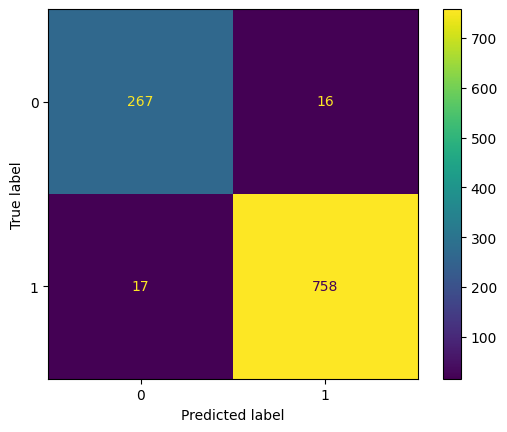

In [315]:
c_m=confusion_matrix(labels_test,val_pred_labels)
c_m_d=ConfusionMatrixDisplay(c_m)
c_m_d.plot()

In [316]:
acc=accuracy_score(labels_test,val_pred_labels)
specificity=specificity_score(labels_test,val_pred_labels)
print(f"Accuracy: {acc}")
print(f"Specificity: {specificity}") #Métrica para ver qué tan bien predice el modelo la clase negativa

Accuracy: 0.9688090737240076
Specificity: 0.9434628975265018


## Accuracy: 96%
## Specificity: 94%

-----------------



# Métricas del modelo VGG16 aplicando balanceo de clases, pero NO FineTuning

In [290]:
#Balanceo de clases mediante class_weight para otorgarle una penalización mayor cuando el modelo se equivoca
#en clasificar una imagen perteneciente a la clase minoritaria
from sklearn.utils.class_weight import compute_class_weight
labels_train=np.unique(train_gen.labels)

pesos=compute_class_weight(class_weight="balanced",classes=labels_train,y=train_gen.labels)

In [291]:
dict_pesos={i:pesos[i] for i in range(len(labels_train))}

In [292]:
print(pesos)
print(dict_pesos)

[1.99622285 0.66708741]
{0: 1.9962228517469311, 1: 0.6670874092773745}


In [293]:
#Creo el mismo modelo, pero aplicando class_weight
VGG16_2=vgg16.VGG16(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet"
)

In [294]:
VGG16_2.trainable=False 

In [295]:
VGG16_2.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [297]:
x_2=VGG16_2.output
x_2=layers.Flatten()(x_2)
x_2=layers.Dense(1000,activation="relu",kernel_regularizer=L2(0.01))(x_2) #Ir probando los valores de L2
output2=layers.Dense(1,activation="sigmoid")(x_2)
modelo2=keras.Model(VGG16_2.input,output2)

In [298]:
modelo2.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1000)                │      25,089,000 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 39,804,689 (151.84 MB)

 Trainable params: 25,090,001 (95.71 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [299]:
modelo2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [300]:
ES2=EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [301]:
#Entreno la red neuronal convolucional, aplicando los pesos de class_weight
modelo2.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[ES2],
    class_weight=dict_pesos
)

Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 90s 405ms/step - accuracy: 0.8024 - loss: 5.0944 - val_accuracy: 0.9612 - val_loss: 0.3393
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 397ms/step - accuracy: 0.8873 - loss: 0.5004 - val_accuracy: 0.9490 - val_loss: 0.2858
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 396ms/step - accuracy: 0.9250 - loss: 0.3075 - val_accuracy: 0.8686 - val_loss: 0.4676
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 392ms/step - accuracy: 0.9009 - loss: 0.3848 - val_accuracy: 0.9357 - val_loss: 0.2882
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 396ms/step - accuracy: 0.9174 - loss: 0.3122 - val_accuracy: 0.9556 - val_loss: 0.3163


In [306]:
#Valores predichos
val_pred2=modelo2.predict(val_gen)  #test_gen
val_pred_n2=val_pred2.reshape(val_pred2.shape[0],)

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step


In [307]:
val_pred_labels2=(val_pred_n2>0.5).astype("int32") #Valores predichos

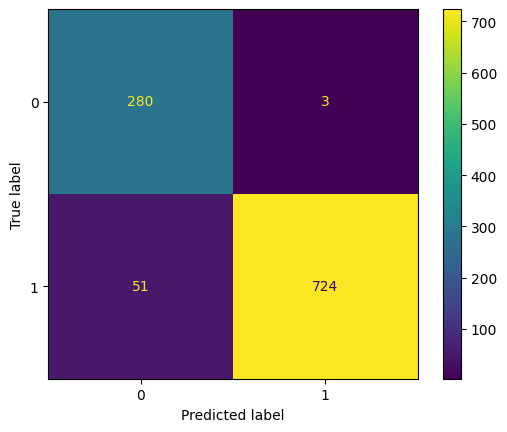

In [308]:
c_m2=confusion_matrix(labels_test,val_pred_labels2)
c_m_d2=ConfusionMatrixDisplay(c_m2)
c_m_d2.plot()

In [309]:
acc2=accuracy_score(labels_test,val_pred_labels2)
specificity2=specificity_score(labels_test,val_pred_labels2)
print(f"Accuracy: {acc2}")
print(f"Specificity: {specificity2}") #Métrica para ver qué tan bien predice el modelo la clase negativa

Accuracy: 0.9489603024574669
Specificity: 0.9893992932862191


# Al aplicar class_weight, la métrica "specificity" aumentó. Lo cual es bueno, ya que se toma en cuenta la clase minoritaria.
# Lo cual puede ser beneficioso en data no antes vista y el modelo no sea sesgado hacia la data de clase mayoritaria.

============

# **CONCLUSIÓN**: Es mejor usar class_weight para hacer el fine-tuning en este dataset

===========
# GlobalAveragePooling en vez de Flatten - NO FINE TUNING

In [336]:
#Creo el mismo modelo, pero aplicando class_weight
VGG16_3=vgg16.VGG16(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet"
)

In [337]:
VGG16_3.trainable=False 

In [338]:
x_3=VGG16_3.output
#x_3=layers.GlobalAveragePooling2D()(x_3)
x_3=layers.Flatten()(x_3)
x_3=layers.Dense(1000,activation="relu",kernel_regularizer=L2(0.01))(x_3) #Ir probando los valores de L2
x_3=layers.Dropout(0.3)(x_3) #Capa de dropout
x_3=layers.BatchNormalization()(x_3) 
output3=layers.Dense(1,activation="sigmoid")(x_3)
modelo3=keras.Model(VGG16_3.input,output3)

In [339]:
modelo3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [340]:
ES3=EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [341]:
#Entreno la red neuronal convolucional, aplicando los pesos de class_weight
modelo3.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[ES3],
    class_weight=dict_pesos
)

Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 91s 404ms/step - accuracy: 0.8284 - loss: 4.3291 - val_accuracy: 0.2675 - val_loss: 2.1400
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 396ms/step - accuracy: 0.8928 - loss: 0.6196 - val_accuracy: 0.2864 - val_loss: 1.3811
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 396ms/step - accuracy: 0.8750 - loss: 0.5739 - val_accuracy: 0.5539 - val_loss: 0.9263
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 399ms/step - accuracy: 0.8780 - loss: 0.5135 - val_accuracy: 0.9575 - val_loss: 0.4921
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 398ms/step - accuracy: 0.8724 - loss: 0.5138 - val_accuracy: 0.3242 - val_loss: 1.3638
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 396ms/step - accuracy: 0.8289 - loss: 0.6000 - val_accuracy: 0.8573 - val_loss: 0.6418
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 394ms/step - accuracy: 0.8439 - loss: 0.5514 - val_accuracy: 0.2684 - val_loss: 1.2207


In [342]:
#Valores predichos
val_pred3=modelo3.predict(val_gen)  #test_gen
val_pred_n3=val_pred3.reshape(val_pred3.shape[0],)
val_pred_labels3=(val_pred_n3>0.5).astype("int32") #Valores predichos

53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step


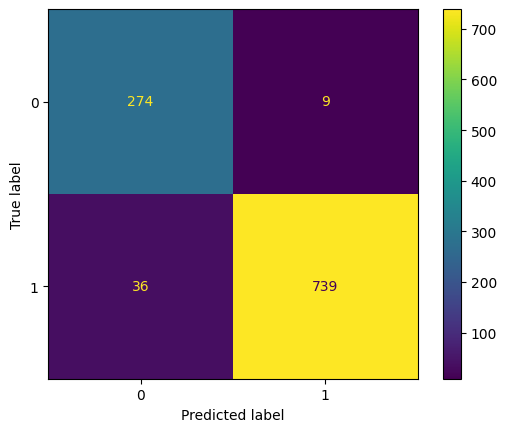

In [343]:
c_m3=confusion_matrix(labels_test,val_pred_labels3)
c_m_d3=ConfusionMatrixDisplay(c_m3)
c_m_d3.plot()

In [344]:
acc3=accuracy_score(labels_test,val_pred_labels3)
specificity3=specificity_score(labels_test,val_pred_labels3)
print(f"Accuracy: {acc3}")
print(f"Specificity: {specificity3}")

Accuracy: 0.9574669187145558
Specificity: 0.9681978798586572


Modelo 3 presenta mejor performance tanto en accuracy, como specificity

========================
# FINETUNING

In [418]:
#Creo el mismo modelo, pero aplicando class_weight
VGG16_4=vgg16.VGG16(
    include_top=False,
    input_shape=(224,224,3),
    weights="imagenet"
)

In [419]:
# Finetuning
VGG16_4.trainable=True

for layer in VGG16_4.layers[:-2]: #Las últimas 2 capas --> última capa convolucional: block5_conv3 (Conv2D) 
    layer.trainable=False #trainable=False, excepto las últimas 2 capas

In [420]:
x_4=VGG16_4.output
x_4=layers.Flatten()(x_4)
x_4=layers.Dense(1000,activation="relu",kernel_regularizer=L2(0.01))(x_4) #Ir probando los valores de L2
x_4=layers.Dropout(0.4)(x_4) #Capa de dropout (0.3)
x_4=layers.BatchNormalization()(x_4) 
output4=layers.Dense(1,activation="sigmoid")(x_4)
modelo4=keras.Model(VGG16_4.input,output4)

In [421]:
modelo4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [422]:
ES4=EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [423]:
#Entreno la red neuronal convolucional, aplicando los pesos de class_weight
modelo4.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[ES4],
    class_weight=dict_pesos
)

Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 93s 411ms/step - accuracy: 0.8317 - loss: 4.2851 - val_accuracy: 0.6059 - val_loss: 1.4241
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 397ms/step - accuracy: 0.9264 - loss: 0.6230 - val_accuracy: 0.9253 - val_loss: 0.4251
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 395ms/step - accuracy: 0.9423 - loss: 0.4111 - val_accuracy: 0.9036 - val_loss: 0.4854
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 395ms/step - accuracy: 0.9483 - loss: 0.3531 - val_accuracy: 0.8658 - val_loss: 0.5028
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 398ms/step - accuracy: 0.9545 - loss: 0.2955 - val_accuracy: 0.9792 - val_loss: 0.2075
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 88s 402ms/step - accuracy: 0.9517 - loss: 0.2616 - val_accuracy: 0.9745 - val_loss: 0.1950
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 398ms/step - accuracy: 0.9543 - loss: 0.2338 - val_accuracy: 0.9499 - val_loss: 0.2361
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 393ms/step - accuracy: 0.9604 - loss: 0

In [424]:
#Valores predichos
val_pred4=modelo4.predict(val_gen)  #test_gen
val_pred_n4=val_pred4.reshape(val_pred4.shape[0],)
val_pred_labels4=(val_pred_n4>0.5).astype("int32") #Valores predichos

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step


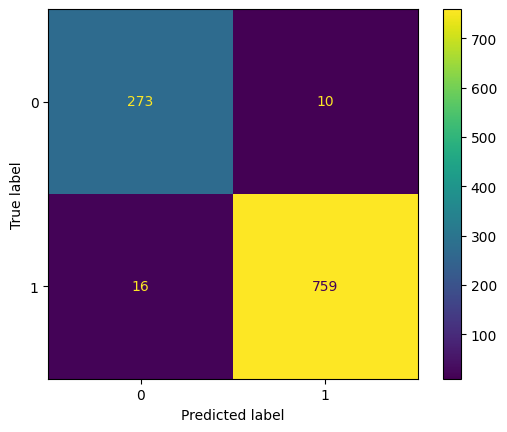

In [425]:
c_m4=confusion_matrix(labels_test,val_pred_labels4)
c_m_d4=ConfusionMatrixDisplay(c_m4)
c_m_d4.plot()

In [426]:
acc4=accuracy_score(labels_test,val_pred_labels4)
specificity4=specificity_score(labels_test,val_pred_labels4)
print(f"Accuracy: {acc4}")
print(f"Specificity: {specificity4}")

Accuracy: 0.9754253308128544
Specificity: 0.9646643109540636


# EVALUANDO LOS MODELOS EN LA DATA DE TEST

# Modelo 1:

In [387]:
val_pred_f=modelo.predict(test_gen)
val_pred_n_f=val_pred_f.reshape(val_pred_f.shape[0],)
val_pred_labels_f=(val_pred_n_f>0.5).astype("int32") #Valores predichos

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step


In [388]:
#Labels de la data de test para ver la métrica 'specifity' (ver qué tan bien predice la clase negativa: normal)
#Pues son menos clases negativas
labels_test_f=test_gen.classes    #Labels reales: test_gen.classes

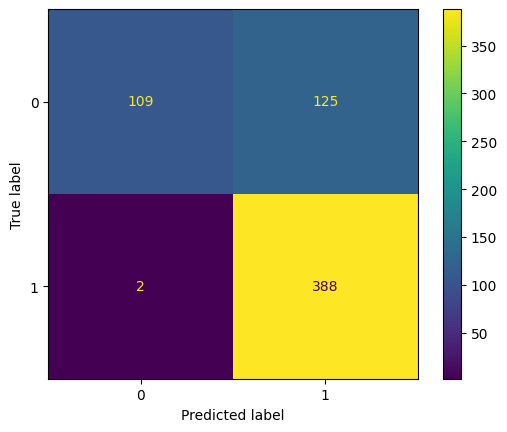

In [389]:
c_m_f=confusion_matrix(labels_test_f,val_pred_labels_f)
c_m_d_f=ConfusionMatrixDisplay(c_m_f)
c_m_d_f.plot()

In [391]:
acc=accuracy_score(labels_test_f,val_pred_labels_f)
specificity=specificity_score(labels_test_f,val_pred_labels_f)
print(f"Accuracy: {acc}")
print(f"Specificity: {specificity}")

Accuracy: 0.7964743589743589
Specificity: 0.4658119658119658


In [432]:
from sklearn.metrics import f1_score
#f1 score del modelo
f1_sc1=f1_score(labels_test_f,val_pred_labels_f)
print(f"f1_score: {f1_sc1}")

f1_score: 0.8593576965669989


# Modelo 2:

In [397]:
#Valores predichos
val_pred2_f=modelo2.predict(test_gen) 
val_pred_n2_f=val_pred2_f.reshape(val_pred2_f.shape[0],)
val_pred_labels2_f=(val_pred_n2_f>0.5).astype("int32") #Valores predichos

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step


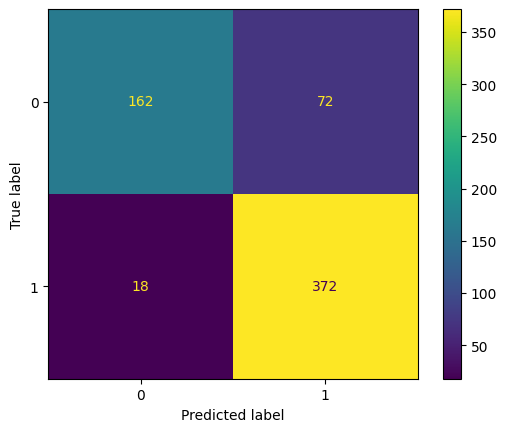

In [398]:
c_m2_f=confusion_matrix(labels_test_f,val_pred_labels2_f)
c_m_d2_f=ConfusionMatrixDisplay(c_m2_f)
c_m_d2_f.plot()

In [399]:
acc2_f=accuracy_score(labels_test_f,val_pred_labels2_f)
specificity2_f=specificity_score(labels_test_f,val_pred_labels2_f)
print(f"Accuracy: {acc2_f}")
print(f"Specificity: {specificity2_f}")

Accuracy: 0.8557692307692307
Specificity: 0.6923076923076923


In [439]:
#f1 score del modelo
f1_sc2=f1_score(labels_test_f,val_pred_labels2_f)
print(f"f1_score: {f1_sc2}")

f1_score: 0.8920863309352518


# Modelo 3: Fine-tuning, Flatten,Dropout (0.3), L2 regularization

In [400]:
#Valores predichos
val_pred3_f=modelo3.predict(test_gen)
val_pred_n3_f=val_pred3_f.reshape(val_pred3_f.shape[0],)
val_pred_labels3_f=(val_pred_n3_f>0.5).astype("int32") #Valores predichos

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step


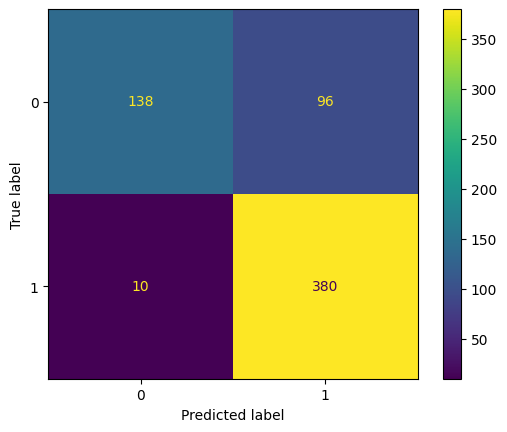

In [401]:
c_m3_f=confusion_matrix(labels_test_f,val_pred_labels3_f)
c_m_d3_f=ConfusionMatrixDisplay(c_m3_f)
c_m_d3_f.plot()

In [402]:
acc3_f=accuracy_score(labels_test_f,val_pred_labels3_f)
specificity3_f=specificity_score(labels_test_f,val_pred_labels3_f)
print(f"Accuracy: {acc3_f}")
print(f"Specificity: {specificity3_f}")

Accuracy: 0.8301282051282052
Specificity: 0.5897435897435898


In [434]:
#f1 score del modelo
f1_sc3=f1_score(labels_test_f,val_pred_labels3_f)
print(f"f1_score: {f1_sc3}")

f1_score: 0.8775981524249423


# Modelo 4

In [427]:
#Valores predichos
val_pred4_f=modelo4.predict(test_gen)
val_pred_n4_f=val_pred4_f.reshape(val_pred4_f.shape[0],)
val_pred_labels4_f=(val_pred_n4_f>0.5).astype("int32") #Valores predichos

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step


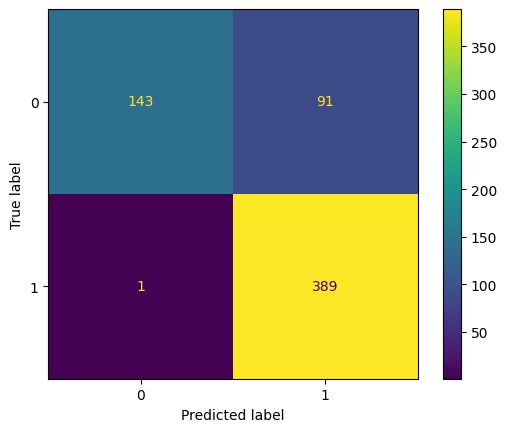

In [440]:
c_m4_f=confusion_matrix(labels_test_f,val_pred_labels4_f)
c_m_d4_f=ConfusionMatrixDisplay(c_m4_f)
c_m_d4_f.plot()

In [441]:
acc4_f=accuracy_score(labels_test_f,val_pred_labels4_f)
specificity4_f=specificity_score(labels_test_f,val_pred_labels4_f)
print(f"Accuracy: {acc4_f}")
print(f"Specificity: {specificity4_f}")

Accuracy: 0.8525641025641025
Specificity: 0.6111111111111112


In [442]:
#f1 score del modelo
f1_sc4=f1_score(labels_test_f,val_pred_labels4_f)
print(f"f1_score: {f1_sc4}")

f1_score: 0.8942528735632183
